In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

import os
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [2]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace = True)

In [3]:
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


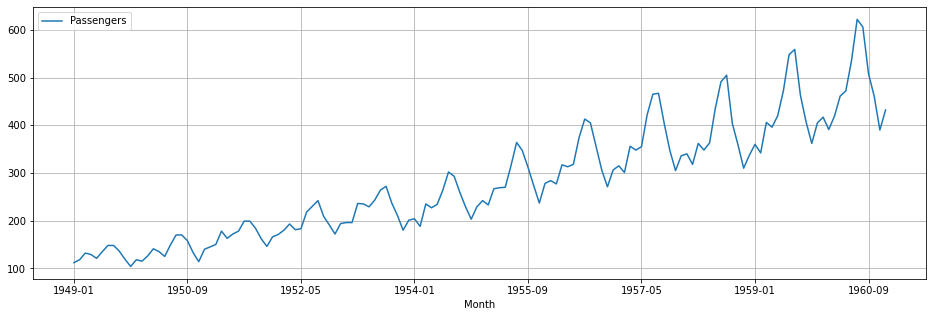

In [5]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

In [6]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
scaler = StandardScaler()
data = df.copy()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, index = df.index, columns = df.columns)
data.describe()

,Passengers
count,1.440000e+02
mean,4.317534e-16
std,1.003490e+00
min,-1.474697e+00
25%,-8.389746e-01
50%,-1.237869e-01
75%,6.708660e-01
max,2.858253e+00


In [8]:
# список признаков, по которым будем учить
#channelIndexes = [0,1, 2, 3] # BRENT
channelIndexes = [0]

# длина теста
valLen = int(len(data)*0.20)
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 5

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data.shape[0] - valLen - bias
# делим
train_data = data.iloc[0 : train_split - 1, channelIndexes]
val_data = data.iloc[train_split + bias:, channelIndexes]

In [9]:
len(train_data), len(val_data)

(110, 28)

In [10]:
# Формируем параметры для генерации выборки
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

In [11]:
# Выделяем части на обучение и проверку
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = data.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal = val_data.iloc[:x_end][[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = data.iloc[label_start:,0].values

In [12]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(110, 1)
(110,)
(24, 1)
(24,)


In [13]:
def create_datasets(batch_size):
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        xTrain,
        yTrain,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        xVal,
        yVal,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )
    return dataset_train, dataset_val

In [14]:
dataset_train, dataset_val = create_datasets(32)

In [15]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 1)
Target shape: (32,)


In [16]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (22, 3, 1)
Target shape: (22,)


In [17]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

### LSTM слои+Conv1D +Dense

In [18]:
def create_model(loss, optimizer):
    model = Sequential()

    model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
    model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
    model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
    #model.add(Conv1D(64, 1, activation="linear"))
    model.add(Flatten())                          # (None, 3*64)
    model.add(Dense(3, activation="linear"))      # (None,3)

    model.add(Dense(1, activation="linear"))

    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    
    return model

In [19]:
callbaсk = EarlyStopping(monitor='val_mae', patience=10)

model = create_model('mse', 'adam')
model.save_weights('model.h5')

In [20]:
res = {}

Epoch 1/10
4/4 [==============================] - 4s 465ms/step - loss: 0.7812 - mae: 0.7846 - val_loss: 2.4831 - val_mae: 1.4410
Epoch 2/10
4/4 [==============================] - 0s 26ms/step - loss: 0.6817 - mae: 0.7309 - val_loss: 2.3357 - val_mae: 1.3907
Epoch 3/10
4/4 [==============================] - 0s 32ms/step - loss: 0.5913 - mae: 0.6780 - val_loss: 2.1283 - val_mae: 1.3154
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.4818 - mae: 0.6095 - val_loss: 1.8487 - val_mae: 1.2046
Epoch 5/10
4/4 [==============================] - 0s 24ms/step - loss: 0.3513 - mae: 0.5145 - val_loss: 1.5014 - val_mae: 1.0570
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 0.2186 - mae: 0.3997 - val_loss: 1.1299 - val_mae: 0.8803
Epoch 7/10
4/4 [==============================] - 0s 26ms/step - loss: 0.1320 - mae: 0.2859 - val_loss: 0.8371 - val_mae: 0.7479
Epoch 8/10
4/4 [==============================] - 0s 25ms/step - loss: 0.1324 - mae: 0.2971 - va

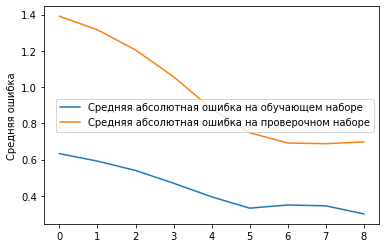

In [21]:
model.load_weights('model.h5')
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

res['as_is'] = [history.history['loss'][-1], history.history['val_loss'][-1]]

plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [22]:
pd.DataFrame.from_dict(res, orient='index', columns = ['mae_train', 'mae_test'])

,mae_train,mae_test
as_is,0.151341,0.772569


In [23]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

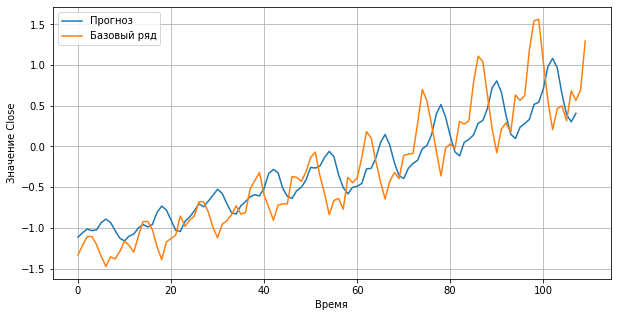

In [24]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Попробуем улучшить

#### epochs

In [25]:
for e in [10, 25, 50, 100, 200, 500]:

    model.load_weights('model.h5')
    history = model.fit(
        dataset_train,
        epochs=e,
        validation_data=dataset_val,
        callbacks=[callbaсk, tensorboard_callback])

    res['epochs_' + str(e)] = [history.history['loss'][-1], history.history['val_loss'][-1]]

Epoch 1/10
4/4 [==============================] - 1s 246ms/step - loss: 0.6255 - mae: 0.6775 - val_loss: 2.5445 - val_mae: 1.4607
Epoch 2/10
4/4 [==============================] - 0s 24ms/step - loss: 0.6123 - mae: 0.6697 - val_loss: 2.4987 - val_mae: 1.4456
Epoch 3/10
4/4 [==============================] - 0s 25ms/step - loss: 0.5935 - mae: 0.6587 - val_loss: 2.4492 - val_mae: 1.4292
Epoch 4/10
4/4 [==============================] - 0s 23ms/step - loss: 0.5732 - mae: 0.6465 - val_loss: 2.3913 - val_mae: 1.4096
Epoch 5/10
4/4 [==============================] - 0s 26ms/step - loss: 0.5493 - mae: 0.6317 - val_loss: 2.3124 - val_mae: 1.3822
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 0.5177 - mae: 0.6113 - val_loss: 2.1956 - val_mae: 1.3403
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 0.4737 - mae: 0.5817 - val_loss: 2.0213 - val_mae: 1.2747
Epoch 8/10
4/4 [==============================] - 0s 24ms/step - loss: 0.4122 - mae: 0.5412 - va

4/4 [==============================] - 0s 23ms/step - loss: 0.1894 - mae: 0.3576 - val_loss: 0.6550 - val_mae: 0.6601
Epoch 11/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1769 - mae: 0.3451 - val_loss: 0.6958 - val_mae: 0.6740
Epoch 12/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1494 - mae: 0.2958 - val_loss: 0.7694 - val_mae: 0.6974
Epoch 13/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1588 - mae: 0.3116 - val_loss: 0.7969 - val_mae: 0.7087
Epoch 14/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1655 - mae: 0.3221 - val_loss: 0.7710 - val_mae: 0.6933
Epoch 15/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1589 - mae: 0.3109 - val_loss: 0.7267 - val_mae: 0.6703
Epoch 16/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1507 - mae: 0.2950 - val_loss: 0.7041 - val_mae: 0.6579
Epoch 17/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1481 - mae: 0.2965 - 

4/4 [==============================] - 0s 27ms/step - loss: 0.1427 - mae: 0.2854 - val_loss: 0.8438 - val_mae: 0.7224
Epoch 21/500
4/4 [==============================] - 0s 25ms/step - loss: 0.1418 - mae: 0.2858 - val_loss: 0.8301 - val_mae: 0.7143
Epoch 22/500
4/4 [==============================] - 0s 28ms/step - loss: 0.1412 - mae: 0.2876 - val_loss: 0.8221 - val_mae: 0.7090
Epoch 23/500
4/4 [==============================] - 0s 26ms/step - loss: 0.1410 - mae: 0.2892 - val_loss: 0.8275 - val_mae: 0.7103
Epoch 24/500
4/4 [==============================] - 0s 25ms/step - loss: 0.1406 - mae: 0.2878 - val_loss: 0.8394 - val_mae: 0.7160
Epoch 25/500
4/4 [==============================] - 0s 24ms/step - loss: 0.1403 - mae: 0.2855 - val_loss: 0.8477 - val_mae: 0.7205


In [26]:
pd.DataFrame.from_dict(res, orient='index', columns = ['mae_train', 'mae_test'])

,mae_train,mae_test
as_is,0.151341,0.772569
epochs_10,0.240450,1.066122
epochs_25,0.143848,0.854385
epochs_50,0.141083,0.853140
epochs_100,0.140651,0.850539
epochs_200,0.140424,0.850441
epochs_500,0.140326,0.847669


#### batch_size

In [27]:
for bs in [4, 8, 16, 32, 64]:
    dataset_train, dataset_val = create_datasets(bs)
    model.load_weights('model.h5')
    history = model.fit(
        dataset_train,
        epochs=100,
        validation_data=dataset_val,
        callbacks=[callbaсk, tensorboard_callback])

    res['bs_' + str(bs)] = [history.history['loss'][-1], history.history['val_loss'][-1]]

Epoch 1/100
27/27 [==============================] - 1s 28ms/step - loss: 0.5756 - mae: 0.6340 - val_loss: 1.8130 - val_mae: 1.1892
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.2014 - mae: 0.3739 - val_loss: 0.9713 - val_mae: 0.7923
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.2472 - mae: 0.4128 - val_loss: 0.8412 - val_mae: 0.7307
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1679 - mae: 0.3246 - val_loss: 0.9618 - val_mae: 0.7915
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1458 - mae: 0.2911 - val_loss: 0.9184 - val_mae: 0.7656
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1458 - mae: 0.2906 - val_loss: 0.9379 - val_mae: 0.7783
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1434 - mae: 0.2870 - val_loss: 0.9570 - val_mae: 0.7906
Epoch 8/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1420 - 

4/4 [==============================] - 0s 24ms/step - loss: 0.1562 - mae: 0.3067 - val_loss: 0.7180 - val_mae: 0.6691
Epoch 17/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1503 - mae: 0.2946 - val_loss: 0.6991 - val_mae: 0.6589
Epoch 18/100
4/4 [==============================] - 0s 25ms/step - loss: 0.1476 - mae: 0.2938 - val_loss: 0.7094 - val_mae: 0.6612
Epoch 19/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1458 - mae: 0.2937 - val_loss: 0.7435 - val_mae: 0.6783
Epoch 20/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1437 - mae: 0.2904 - val_loss: 0.7821 - val_mae: 0.6970
Epoch 21/100
4/4 [==============================] - 0s 25ms/step - loss: 0.1427 - mae: 0.2871 - val_loss: 0.8076 - val_mae: 0.7089
Epoch 22/100
4/4 [==============================] - 0s 25ms/step - loss: 0.1425 - mae: 0.2858 - val_loss: 0.8150 - val_mae: 0.7114
Epoch 23/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1419 - mae: 0.2857 - 

In [28]:
pd.DataFrame.from_dict(res, orient='index', columns = ['mae_train', 'mae_test'])

,mae_train,mae_test
as_is,0.151341,0.772569
epochs_10,0.240450,1.066122
epochs_25,0.143848,0.854385
epochs_50,0.141083,0.853140
epochs_100,0.140651,0.850539
epochs_200,0.140424,0.850441
epochs_500,0.140326,0.847669
bs_4,0.133604,0.924220
bs_8,0.180194,0.716834
bs_16,0.139264,0.877765


размер батча 8 чуть улучшил ситуацию на тесте и немного сократил разрыв между трейном и тестом, но разница между трейном и тестом по прежнему значительна

### loss function

In [29]:
for lf in ['mse', 'mae', 'msle']:
    dataset_train, dataset_val = create_datasets(8)
    model = create_model(lf, 'adam')
    model.load_weights('model.h5')
    history = model.fit(
        dataset_train,
        epochs=100,
        validation_data=dataset_val,
        callbacks=[callbaсk, tensorboard_callback])

    res['lf_' + str(lf)] = [history.history['loss'][-1], history.history['val_loss'][-1]]

Epoch 1/100
14/14 [==============================] - 4s 123ms/step - loss: 0.8867 - mae: 0.8477 - val_loss: 2.1940 - val_mae: 1.3405
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.3937 - mae: 0.5525 - val_loss: 1.2878 - val_mae: 0.9623
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0935 - mae: 0.2390 - val_loss: 1.0538 - val_mae: 0.8406
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.1332 - mae: 0.3018 - val_loss: 0.7122 - val_mae: 0.6715
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0857 - mae: 0.2208 - val_loss: 0.8626 - val_mae: 0.7391
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1074 - mae: 0.2536 - val_loss: 0.7912 - val_mae: 0.7012
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0871 - mae: 0.2337 - val_loss: 1.0168 - val_mae: 0.8214
Epoch 8/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1146 -

In [30]:
pd.DataFrame.from_dict(res, orient='index', columns = ['mae_train', 'mae_test'])

,mae_train,mae_test
as_is,0.151341,0.772569
epochs_10,0.240450,1.066122
epochs_25,0.143848,0.854385
epochs_50,0.141083,0.853140
epochs_100,0.140651,0.850539
epochs_200,0.140424,0.850441
epochs_500,0.140326,0.847669
bs_4,0.133604,0.924220
bs_8,0.180194,0.716834
bs_16,0.139264,0.877765


msle показала ощутимо лучший результат

#### optimizer

In [31]:
for opt in ['rmsprop', 'sgd', 'adam', 'nadam']:
    dataset_train, dataset_val = create_datasets(8)
    model = create_model('msle', opt)
    model.load_weights('model.h5')
    history = model.fit(
        dataset_train,
        epochs=100,
        validation_data=dataset_val,
        callbacks=[callbaсk, tensorboard_callback])

    res['opt_' + str(opt)] = [history.history['loss'][-1], history.history['val_loss'][-1]]

Epoch 1/100
14/14 [==============================] - 4s 127ms/step - loss: 0.0160 - mae: 0.8422 - val_loss: 0.3570 - val_mae: 1.0719
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0100 - mae: 0.7632 - val_loss: 0.1702 - val_mae: 0.7653
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.7715 - val_loss: 0.1603 - val_mae: 0.7437
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0105 - mae: 0.7794 - val_loss: 0.1606 - val_mae: 0.7445
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.7739 - val_loss: 0.1613 - val_mae: 0.7471
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.7663 - val_loss: 0.1619 - val_mae: 0.7501
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.7577 - val_loss: 0.1624 - val_mae: 0.7527
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0102 

14/14 [==============================] - 0s 8ms/step - loss: 0.0207 - mae: 0.9818 - val_loss: 0.4830 - val_mae: 1.2196
Epoch 51/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0205 - mae: 0.9809 - val_loss: 0.4807 - val_mae: 1.2174
Epoch 52/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0203 - mae: 0.9800 - val_loss: 0.4783 - val_mae: 1.2151
Epoch 53/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0201 - mae: 0.9791 - val_loss: 0.4759 - val_mae: 1.2128
Epoch 54/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0199 - mae: 0.9781 - val_loss: 0.4734 - val_mae: 1.2104
Epoch 55/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0197 - mae: 0.9772 - val_loss: 0.4710 - val_mae: 1.2080
Epoch 56/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0195 - mae: 0.9762 - val_loss: 0.4685 - val_mae: 1.2056
Epoch 57/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0193 - mae: 0

14/14 [==============================] - 0s 8ms/step - loss: 0.0090 - mae: 0.6623 - val_loss: 0.1984 - val_mae: 0.8385
Epoch 13/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0089 - mae: 0.6458 - val_loss: 0.1992 - val_mae: 0.8411
Epoch 14/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0087 - mae: 0.6274 - val_loss: 0.2007 - val_mae: 0.8449
Epoch 1/100
14/14 [==============================] - 4s 129ms/step - loss: 0.0166 - mae: 0.8708 - val_loss: 0.5239 - val_mae: 1.2561
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0103 - mae: 0.8223 - val_loss: 0.2009 - val_mae: 0.8335
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0108 - mae: 0.8015 - val_loss: 0.1599 - val_mae: 0.7428
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0105 - mae: 0.7736 - val_loss: 0.1663 - val_mae: 0.7583
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0102 - mae: 0.76

In [32]:
pd.DataFrame.from_dict(res, orient='index', columns = ['mae_train', 'mae_test'])

,mae_train,mae_test
as_is,0.151341,0.772569
epochs_10,0.240450,1.066122
epochs_25,0.143848,0.854385
epochs_50,0.141083,0.853140
epochs_100,0.140651,0.850539
epochs_200,0.140424,0.850441
epochs_500,0.140326,0.847669
bs_4,0.133604,0.924220
bs_8,0.180194,0.716834
bs_16,0.139264,0.877765


Самый лучший результат показала модель с размером батча = 8, оптимизацией rmsprop и функцией потерь msle. При этом наибольшее влияние на результат в данном случае оказал выбор функции потерь

### final model

In [33]:
dataset_train, dataset_val = create_datasets(8)
final_model = create_model('msle', 'rmsprop')
final_model.load_weights('model.h5')
history = final_model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

Epoch 1/100
14/14 [==============================] - 4s 106ms/step - loss: 0.0160 - mae: 0.8422 - val_loss: 0.3570 - val_mae: 1.0719
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0100 - mae: 0.7632 - val_loss: 0.1702 - val_mae: 0.7653
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.7715 - val_loss: 0.1603 - val_mae: 0.7437
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 0.0105 - mae: 0.7794 - val_loss: 0.1606 - val_mae: 0.7445
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.7739 - val_loss: 0.1613 - val_mae: 0.7471
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0104 - mae: 0.7663 - val_loss: 0.1619 - val_mae: 0.7501
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.7577 - val_loss: 0.1624 - val_mae: 0.7527
Epoch 8/100
14/14 [==============================] - 0s 8ms/step - loss: 0.0102 -

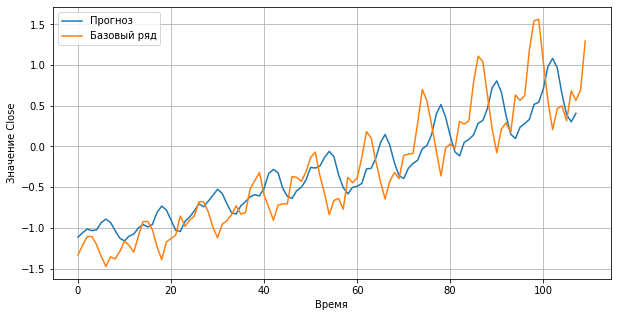

In [34]:
start = 0

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

 При многократном повторении довольно стабильные и относительно неплохие результаты удается получить только на количестве эпох = 100, не самыми лучшими по таблице с метрикой. Самым стабильным параметром, неизменно приводящим к более высоким результатам, при любых других параметрах оказывается размер батча